In [11]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

In [3]:
line_list = Table.read('line_positions.ecsv')

In [4]:
all_sp = line_list

In [5]:
len(line_list[line_list['Xs'] !=  -1.0])

24

In [6]:
line_list = line_list[line_list['Xs'] !=  -1.0]

In [7]:
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

In [8]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

In [9]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    dates.append(date)
    
    
  #  plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
   #     plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
  #  plt.plot(w, f)
  #  plt.plot(w, gg_fit(w))
  #  plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)
    
    #dvs.append(np.mean(dv))
    #print(np.std(dv))
    
    

<ErrorbarContainer object of 3 artists>

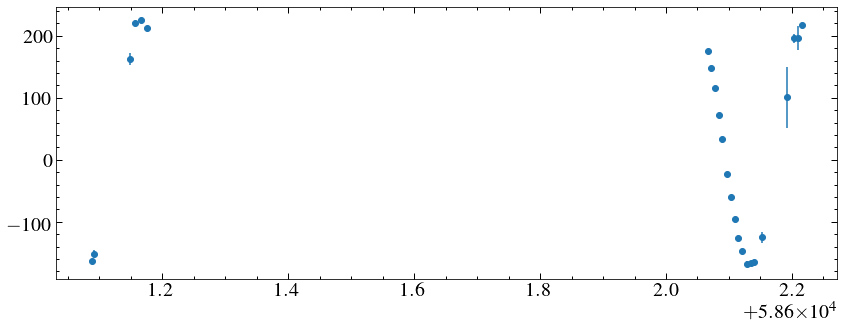

In [15]:
plt.errorbar(dates, dvs, yerr=dves, marker='o', ls='none')

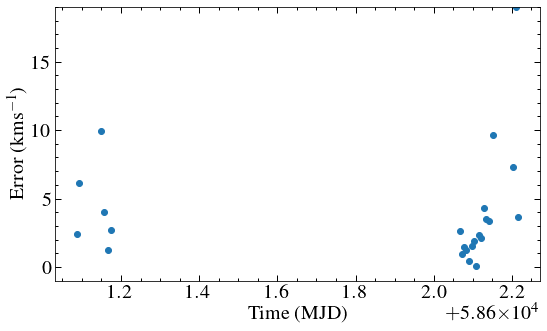

In [16]:
plt.figure(figsize=(8,5))
plt.errorbar(dates, dves, marker='o', ls='none')
plt.ylim(-1, 19)
plt.xlabel('Time (MJD)')
plt.ylabel('Error (kms$^{-1}$)')
plt.tight_layout()
plt.savefig('errortest.png')

In [17]:
from astropy.timeseries import LombScargle

In [18]:

dates = np.array(dates) + (150/86400)
args = np.argsort(dates)

In [19]:
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
t = (t-t[0])*24

<ErrorbarContainer object of 3 artists>

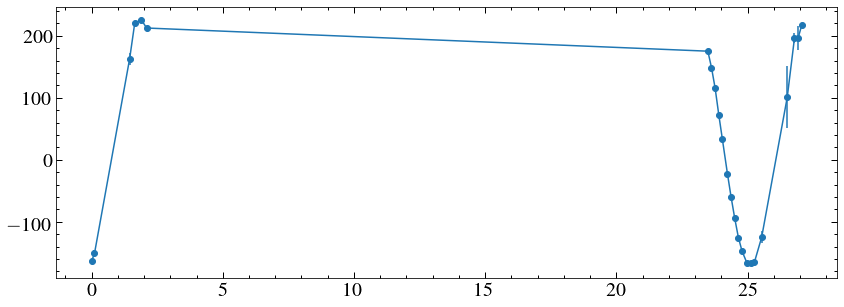

In [20]:
plt.errorbar(t, dvs, yerr=dves, marker='o')

4.217385925598945


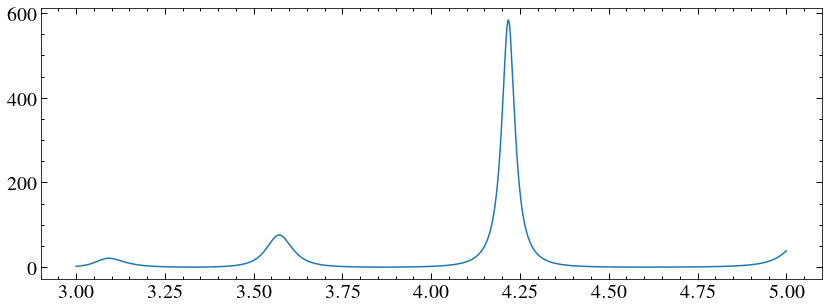

In [21]:

frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(t, dvs, normalization='model').power(frequency)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

<ErrorbarContainer object of 3 artists>

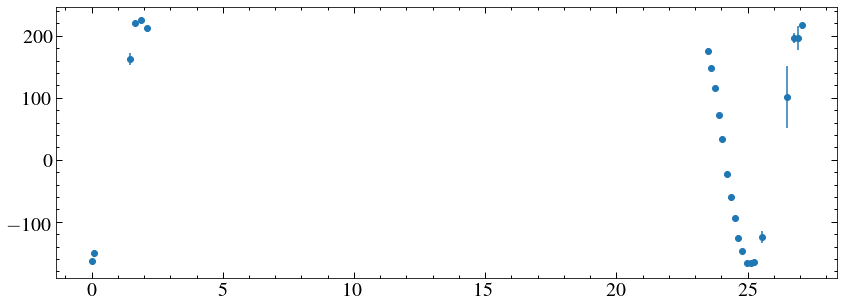

In [22]:
t_fold = (t/period) %1
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 39417.2133428176
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


Model: CompoundModel72
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=27.)>

    [1]: <Sine1D(amplitude=190., frequency=0.23640662, phase=-2260.20259328)>
Parameters:
    amplitude_0 amplitude_1     frequency_1           phase_1      
    ----------- ----------- ------------------- -------------------
           27.0       190.0 0.23640661938534277 -2260.2025932837037
4.23


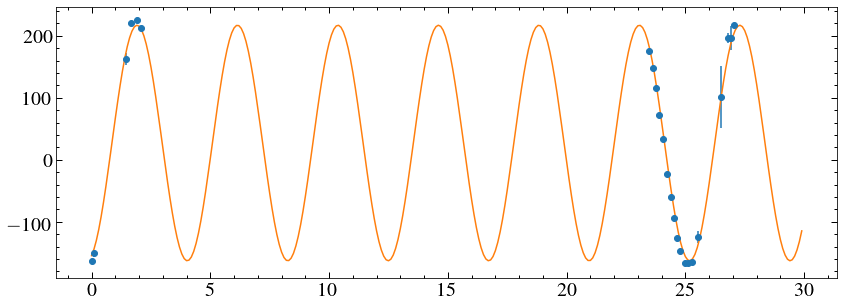

In [23]:
fitter = fitting.SLSQPLSQFitter()
sine_mod =  models.Const1D(27, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=190, frequency=1/4.23, phase = -2260.2025932837037,bounds=dict(amplitude=[170, 250], frequency=[1/4.5, 1/4.1]))
sine_fit = fitter(sine_mod, t, dvs, weights=1/dves, maxiter=100)
print(sine_fit)
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
#phase_t = np.arange(0,1.01, 0.01 )
#plt.plot(phase_t, sine_fit(phase_t))
t_plot = np.arange(0, 30, 0.1)
plt.plot(t_plot, sine_fit(t_plot))
print(1/sine_fit[1].frequency)

In [24]:
print (max(dvs) - abs(min(dvs)))
print(max(dvs - ))

SyntaxError: invalid syntax (<ipython-input-24-e8294cb70142>, line 2)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1157.6216207269667
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11
Model: CompoundModel874
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0       amplitude_1    frequency_1      phase_1      
    ------------------ ---------------- ----------- ------------------
    26.182914824978486 196.152722416969         1.0 -4122.207450606172


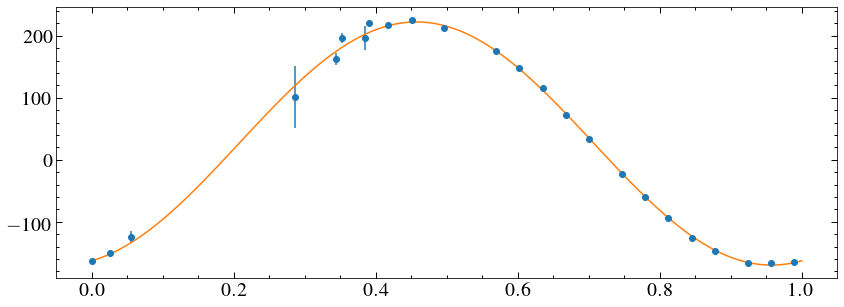

In [53]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, maxiter=100000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 246587.56617620453
            Iterations: 13
            Function evaluations: 118
            Gradient evaluations: 11
Model: CompoundModel870
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0        amplitude_1     frequency_1      phase_1      
    ------------------ ------------------ ----------- ------------------
    36.567591566940564 170.00000000000009         1.0 1074.0828715217956


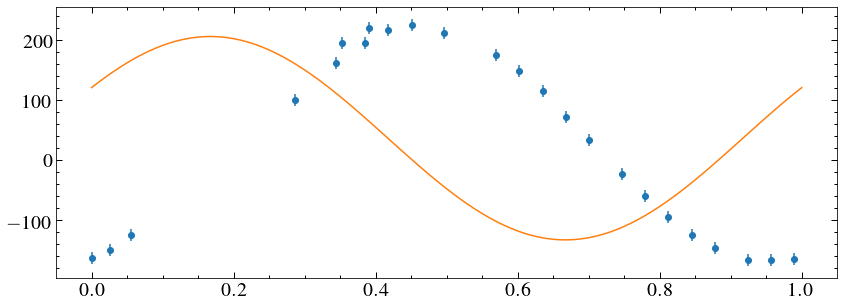

In [49]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()
errs = np.full(len(t_fold), 10)
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[170, 250]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, errs, maxiter=10000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Can't deal with errors for some reason -fixed- weights = 1/e

Try the absorption lines?

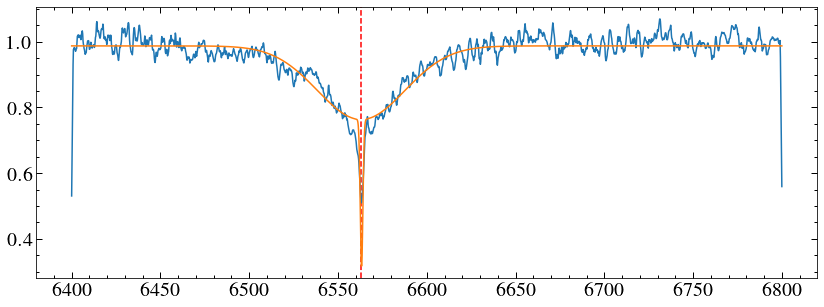

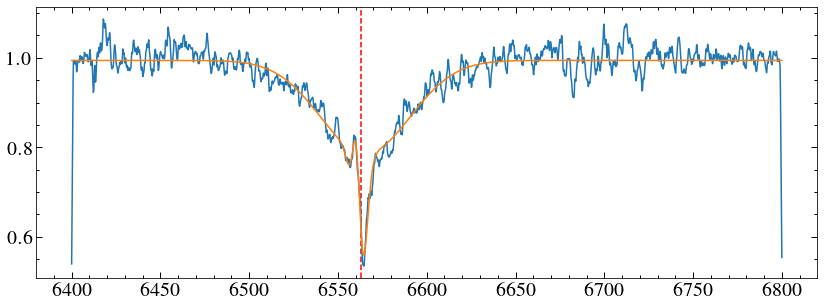

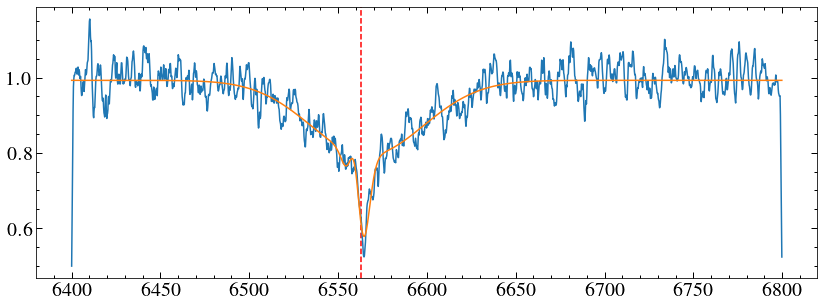

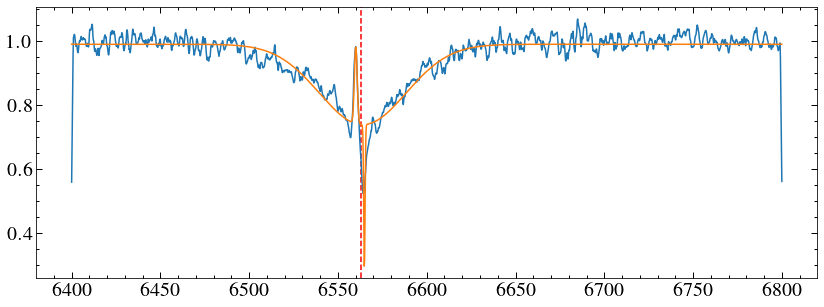

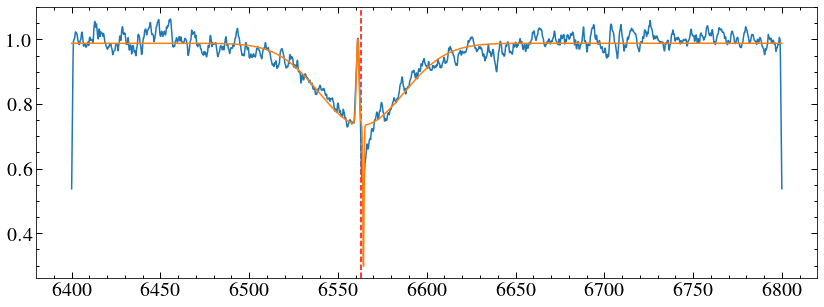

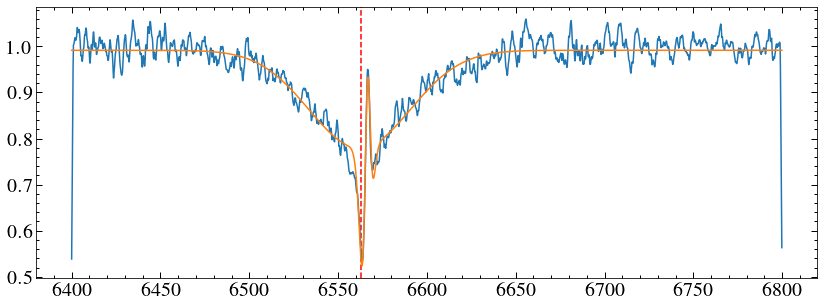

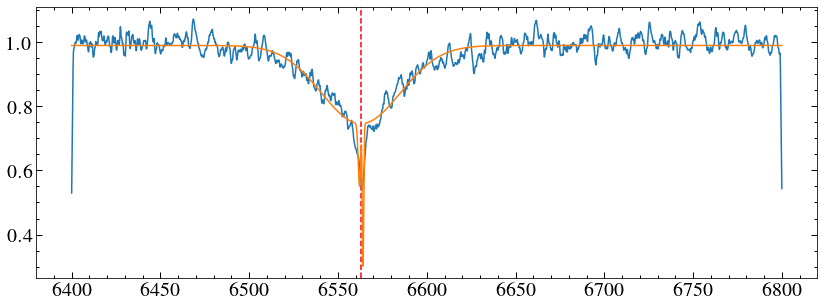

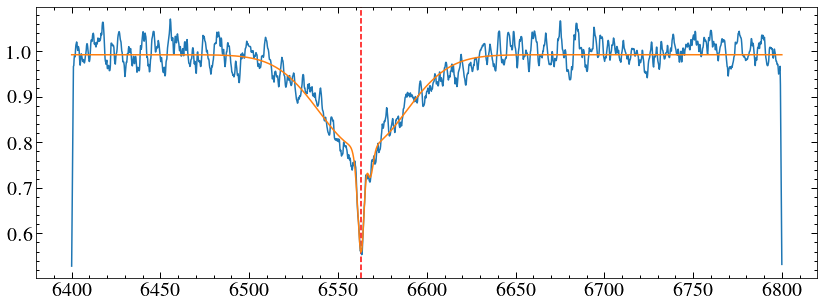

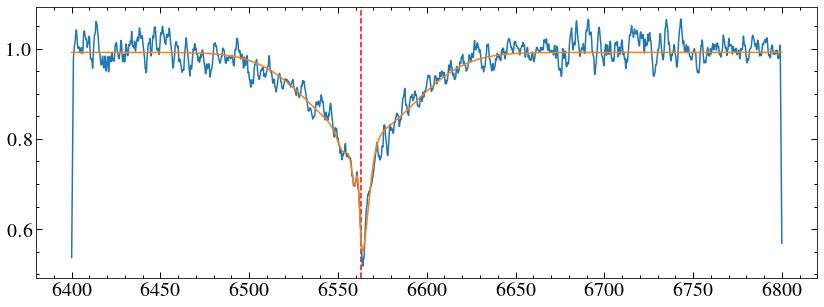

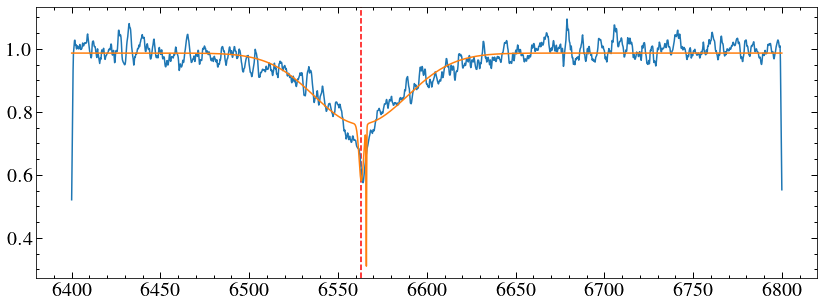

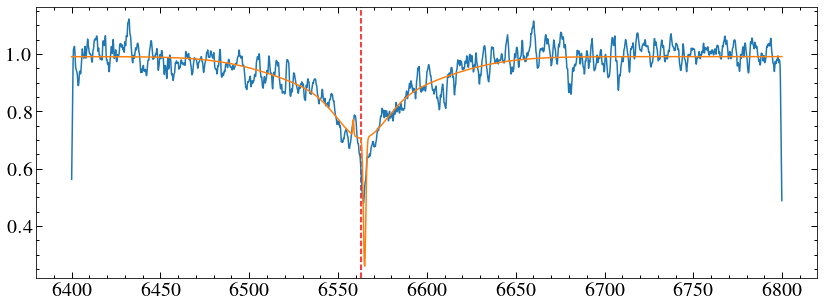

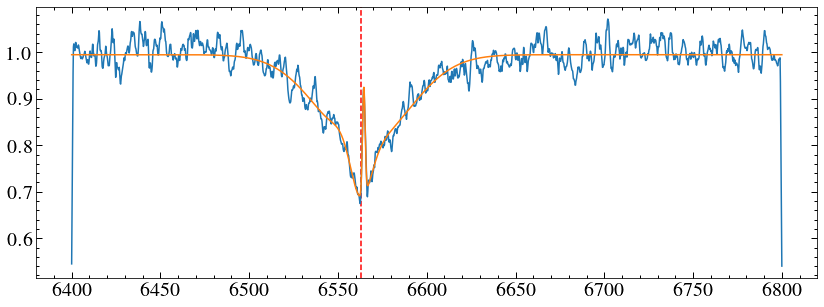

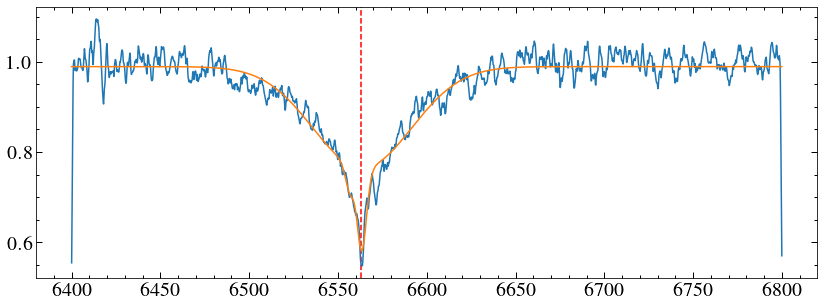

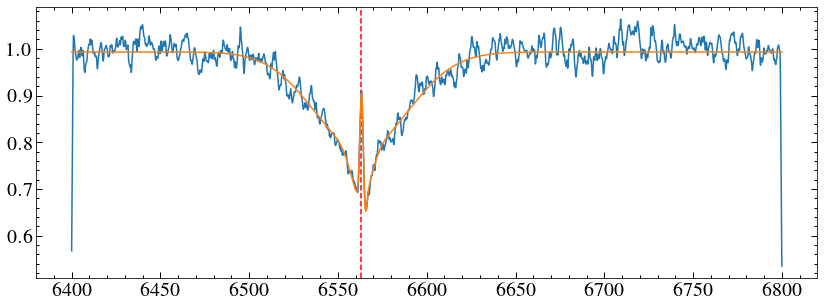

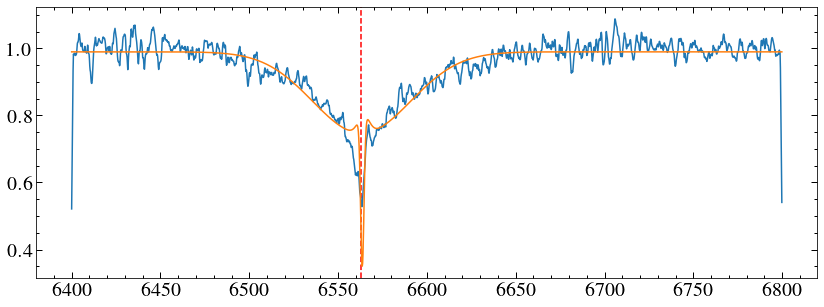

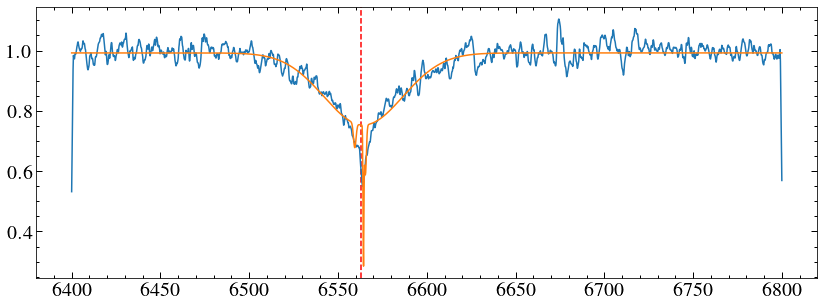

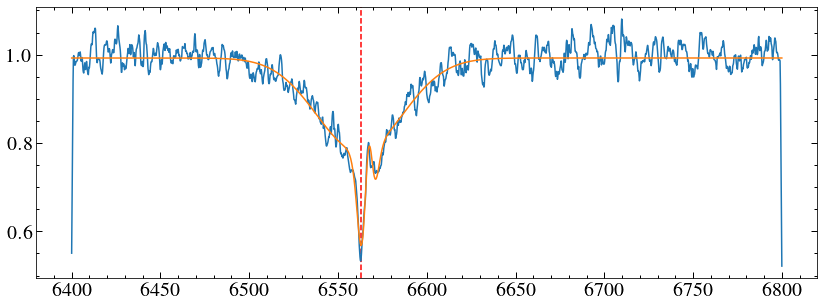

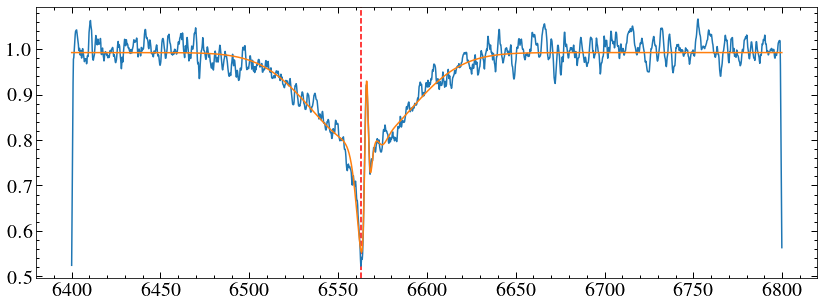

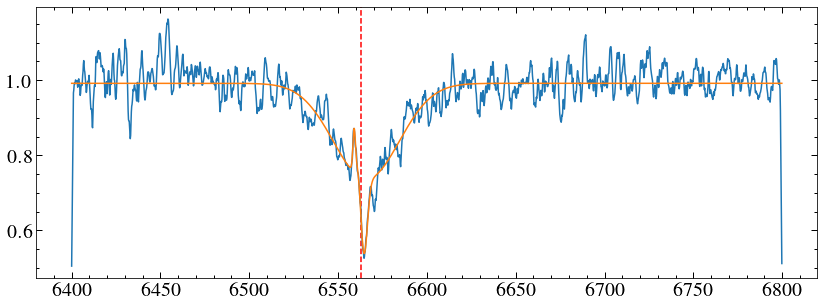

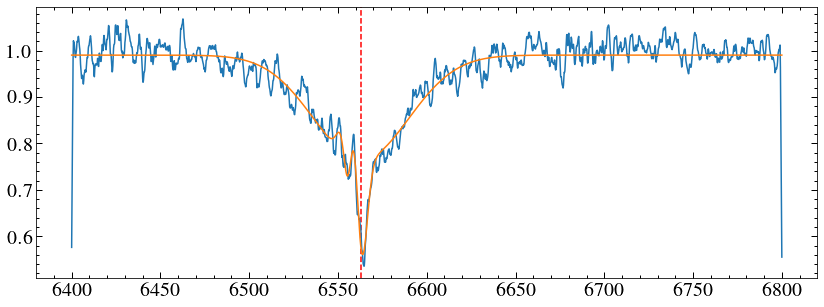

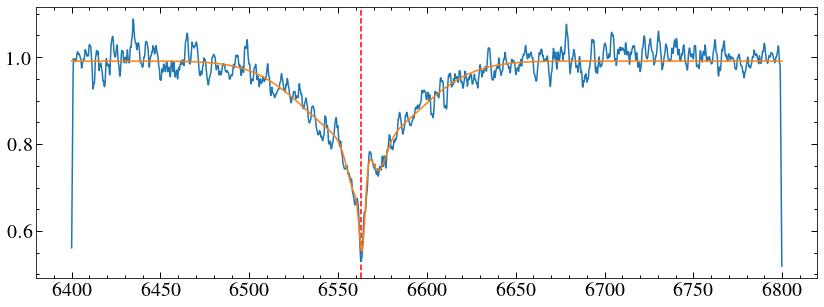

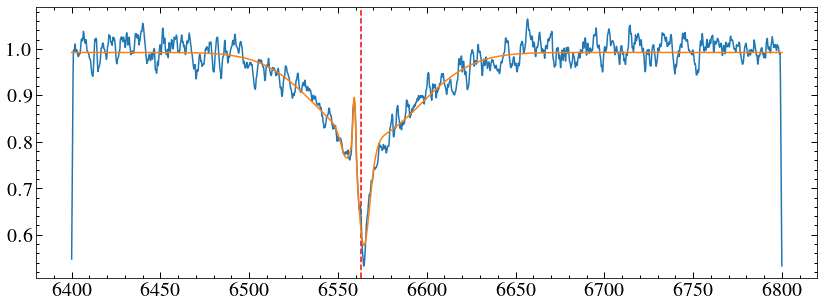

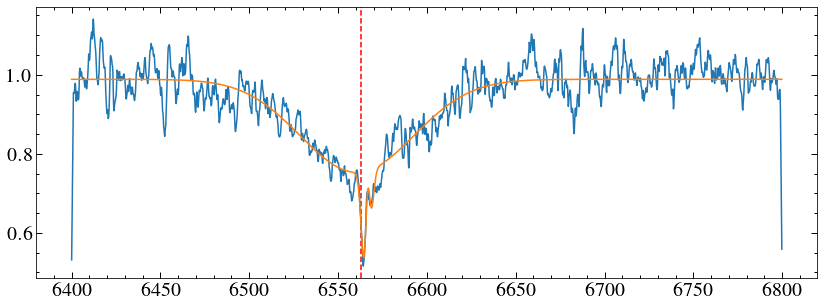

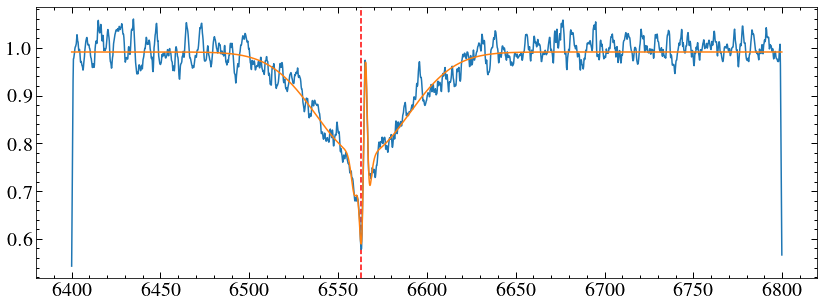

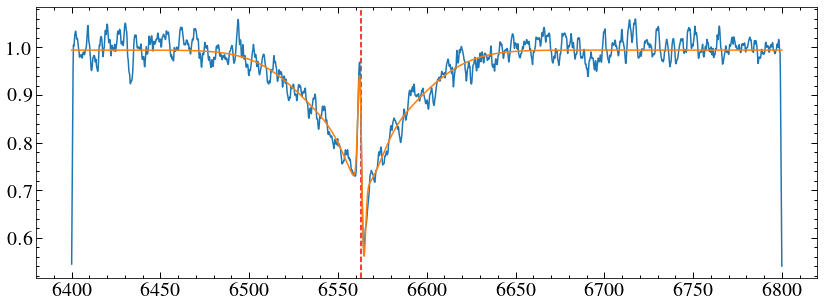

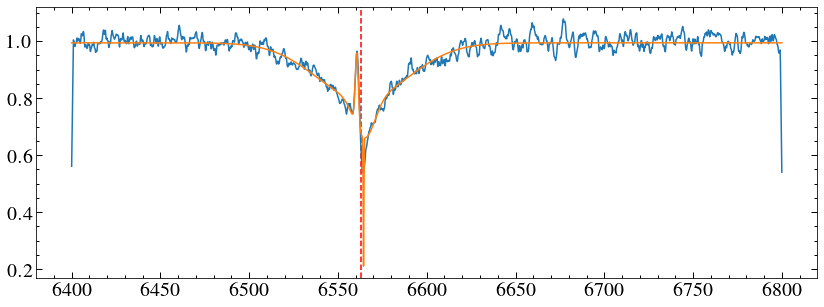

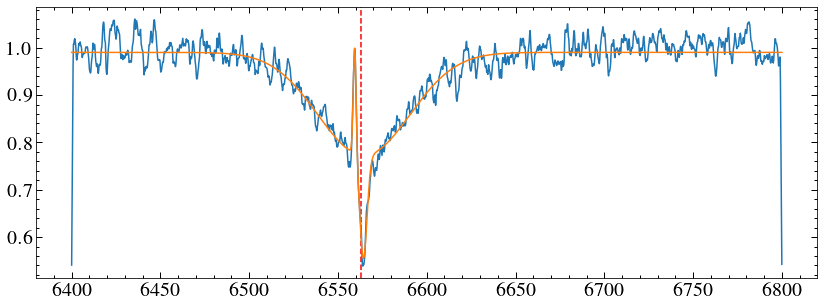

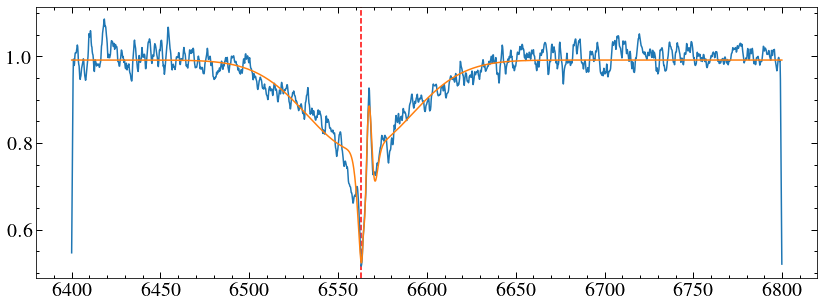

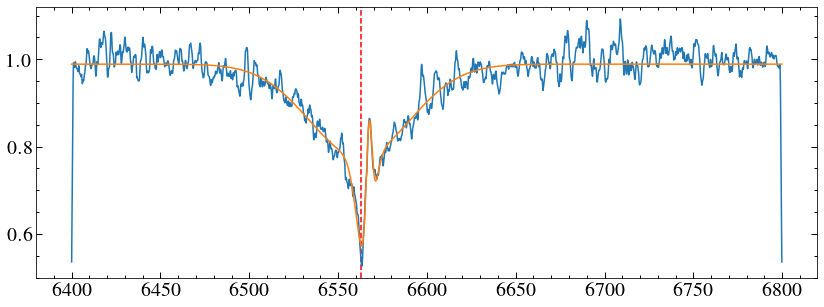

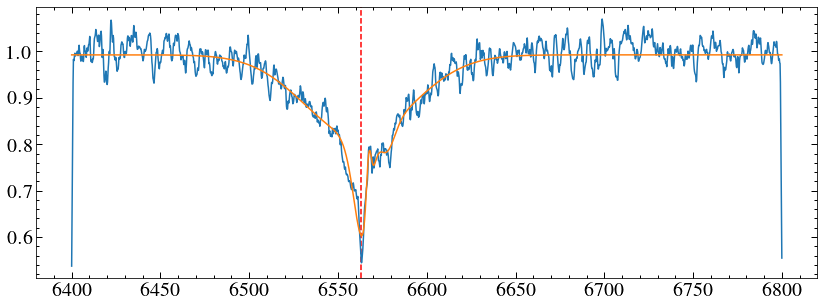

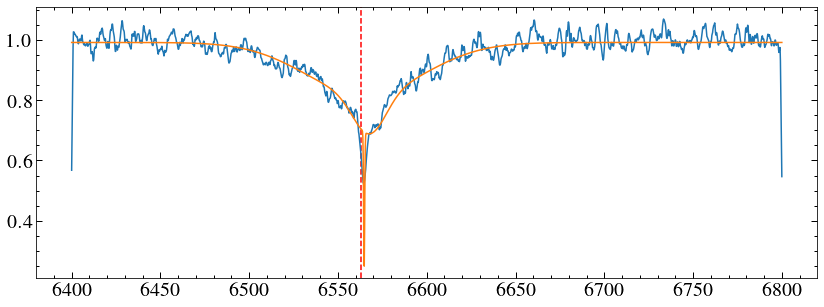

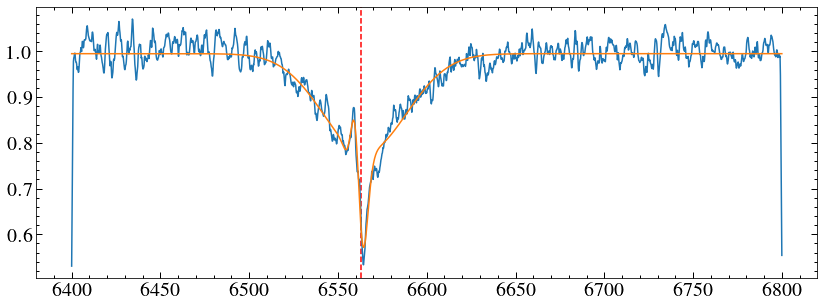

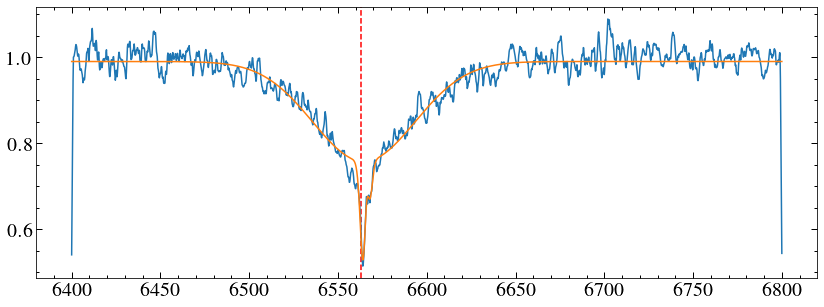

In [60]:
fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77

def tiedfunc(gg_init):
    mean = gg_init.mean_0.value
    return mean

#sp_lines, xs = , line_list
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
    
    
    plt.figure() 
  
    plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Const1D(1.0) + models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5, bounds={'amplitude':[-0.35, -0.45]})+models.Gaussian1D(-0.2, halpha,30) 
    gg_init.mean_1.tied=tiedfunc
    gg_init.mean_2.tied=tiedfunc
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5)
        


    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    
    obs_line = gg_fit[1].mean*u.AA
    #obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    
    abs_dvs.append(dv)
    #abs_dves.append(dve)
    
    

33


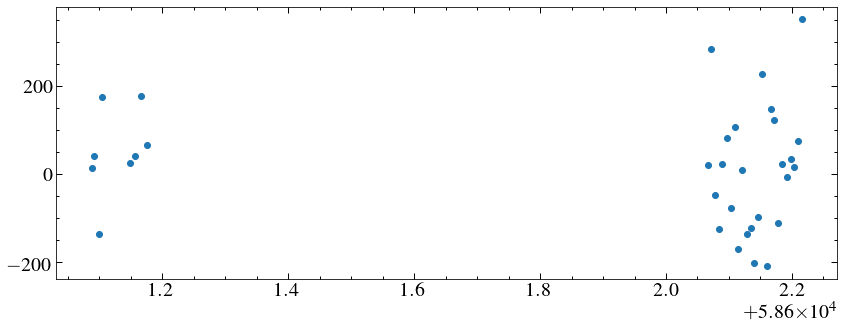

In [61]:
plt.errorbar(abs_dates, abs_dvs, ls='none', marker='o')
print(len(abs_dvs))

<ErrorbarContainer object of 3 artists>

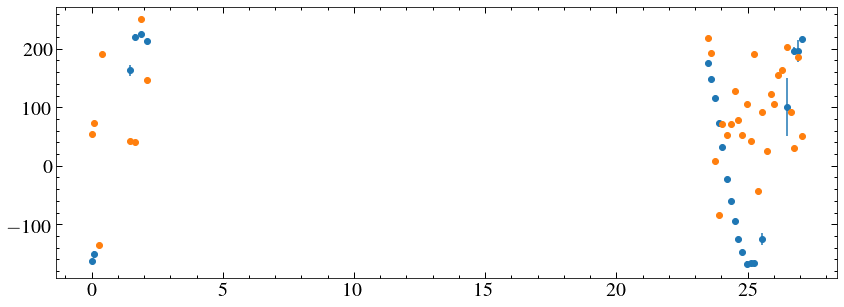

In [34]:
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
t_abs = (abs_dates - min(np.array(abs_dates)))*24
plt.errorbar(t_abs, abs_dvs, ls='none', marker='o')

<ErrorbarContainer object of 3 artists>

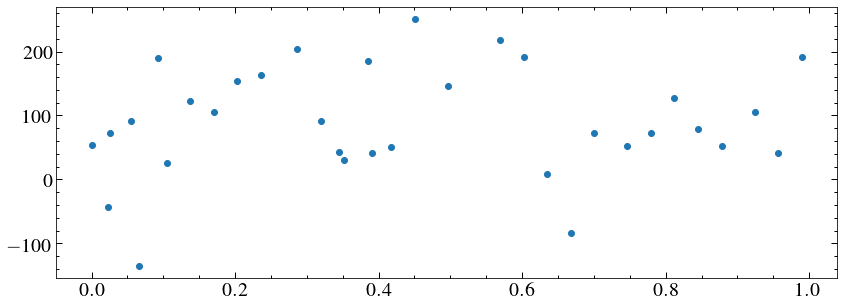

In [35]:
abs_fold = (t_abs/period) %1
plt.errorbar(abs_fold, abs_dvs, ls='none', marker='o')

In [365]:
fake_dv = np.random.normal(dvs, dves)

<ErrorbarContainer object of 3 artists>

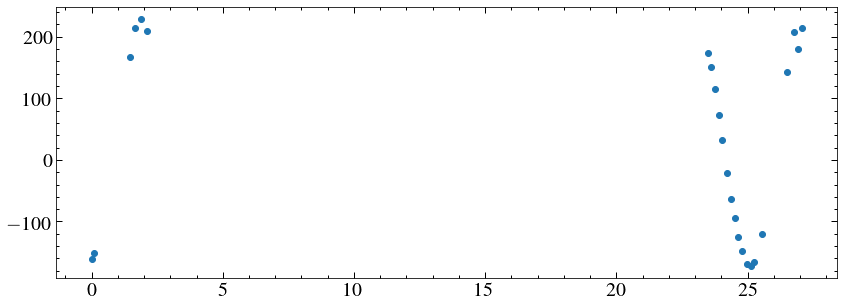

In [316]:
plt.errorbar(t, dv_fake, ls='none', marker='o')

4.217385925598945
4.2167219999831325


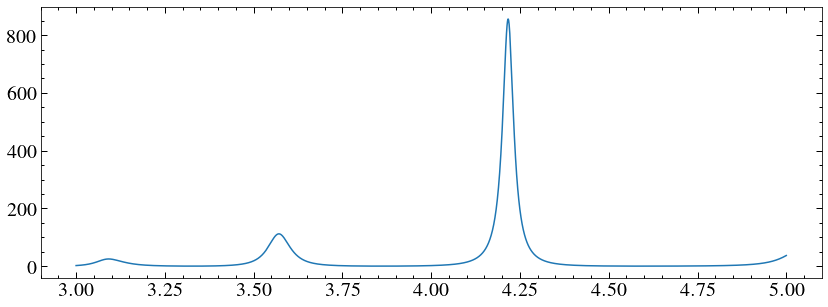

In [366]:
frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(t, fake_dv, normalization='model').power(frequency)
fake_period = 1/frequency[np.argmax(power)]
print(period)
print(fake_period)
plt.plot(1/frequency, power)

In [368]:
fake_periods = []
i = 0
while i < 1000:
    fake_dv = np.random.normal(dvs, dves)
    power = LombScargle(t, fake_dv, normalization='model').power(frequency)
    fake_period = 1/frequency[np.argmax(power)]
    fake_periods.append(fake_period)
    i +=1
    

(array([ 47.,  54.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  29., 301., 433., 126.,  10.]),
 array([3.54681009, 3.56103426, 3.57525843, 3.5894826 , 3.60370677,
        3.61793094, 3.63215511, 3.64637928, 3.66060345, 3.67482762,
        3.6890518 , 3.70327597, 3.71750014, 3.73172431, 3.74594848,
        3.76017265, 3.77439682, 3.78862099, 3.80284516, 3.81706934,
        3.83129351, 3.84551768, 3.85974185, 3.87396602, 3.88819019,
        3.90241436, 3.91663853, 3.9308627 , 3.94508688, 3.95931105,
        3.97353522, 3.98775939, 4.00198356, 4.01620773, 4.0304319 ,
        4.04465607, 4.05888024, 4.07310442, 4.08732859, 4.10155276,
        4.11577693, 4.1300011 , 4.14422527, 4.15844944, 4.17267361,
        4.18689778, 4.20112195, 4.21534613, 4.

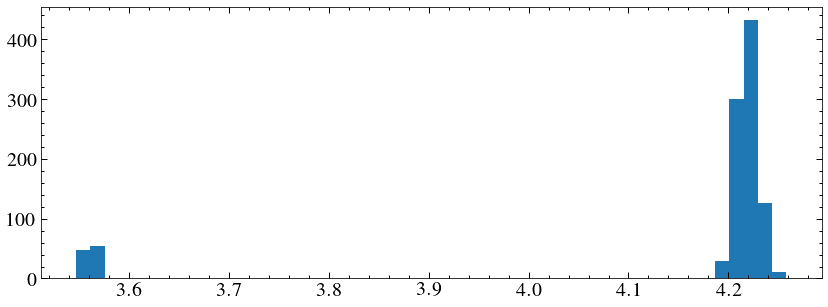

In [369]:
plt.hist(fake_periods, bins=50)

In [374]:
fake_periods = np.array(fake_periods)
print(np.median(fake_periods[fake_periods > 4]))
print (np.std(fake_periods[fake_periods > 4]))

4.218975453755347
0.010140210303638673


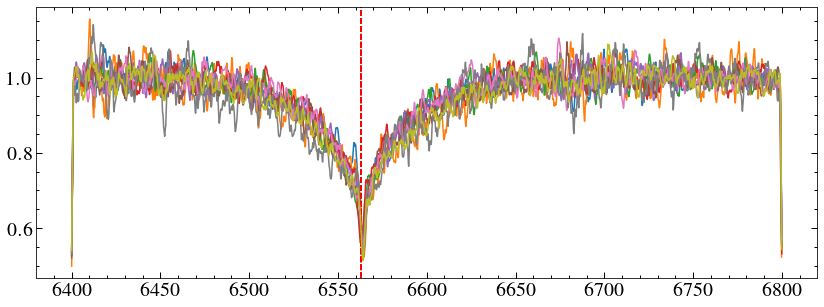

In [377]:

halpha = 6562.77


for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    if x == -1:
   # print(s)
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        slines = get_shifted_lines(x, lines)
        mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
        mask2 = (w> 6400) & (w < 6800) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2)


       # plt.figure() 

        plt.axvline(halpha, c='r', ls='--')

        plt.plot(w, f)

        #plt.show()


    
    

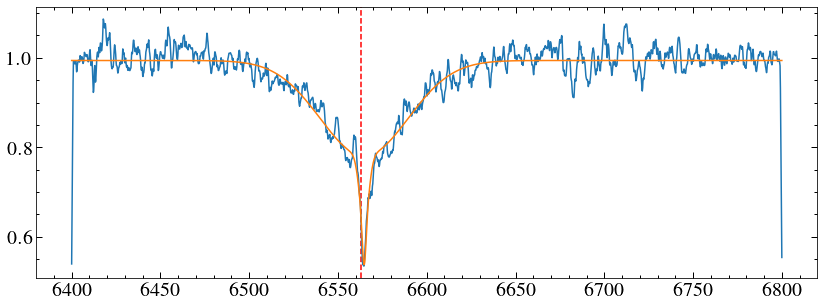

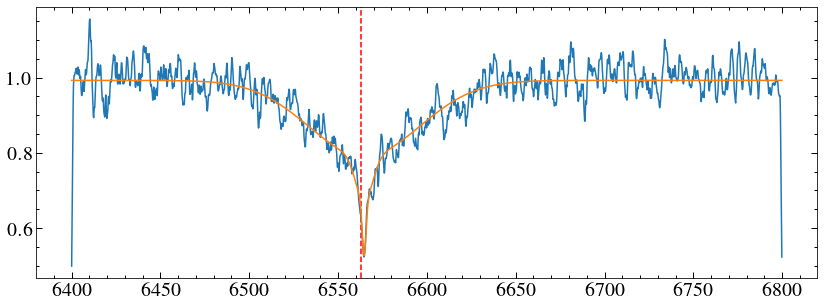

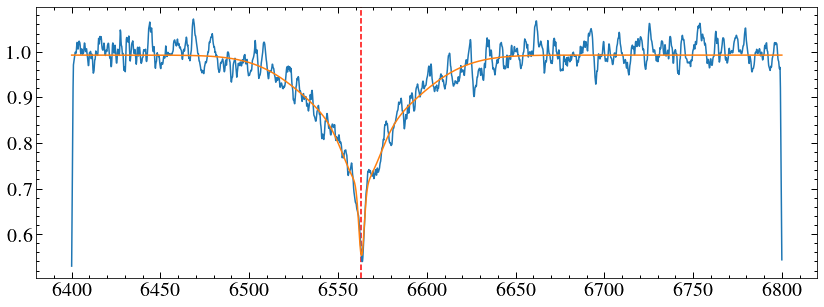

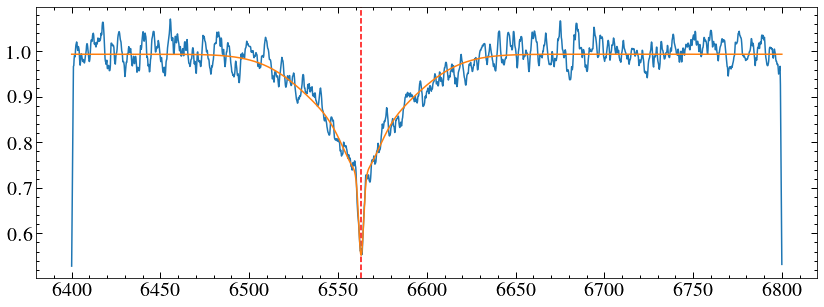

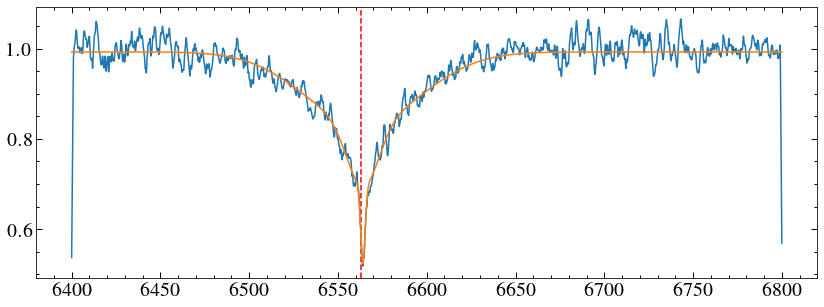

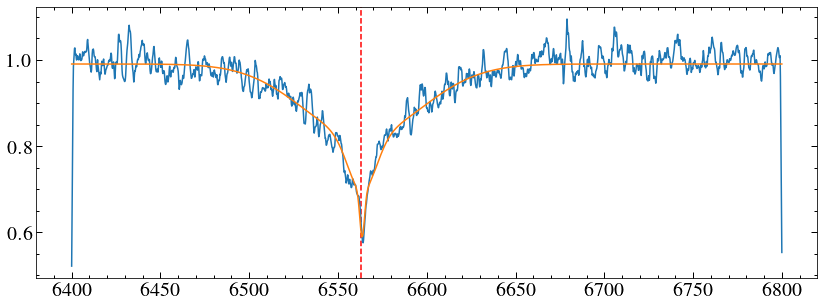

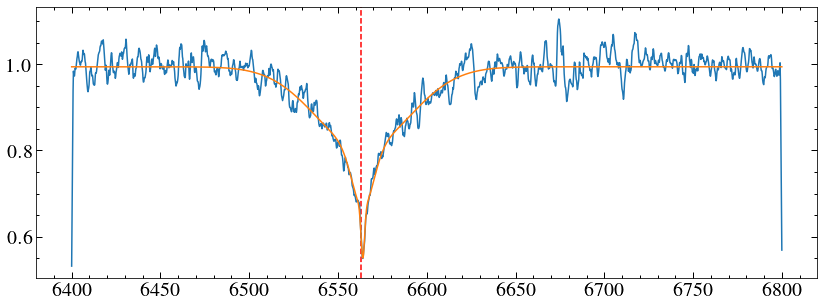

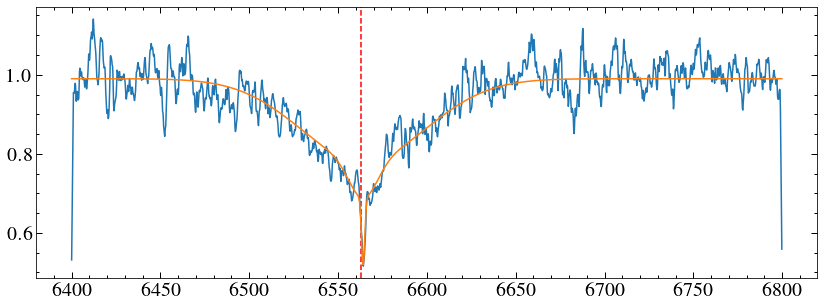

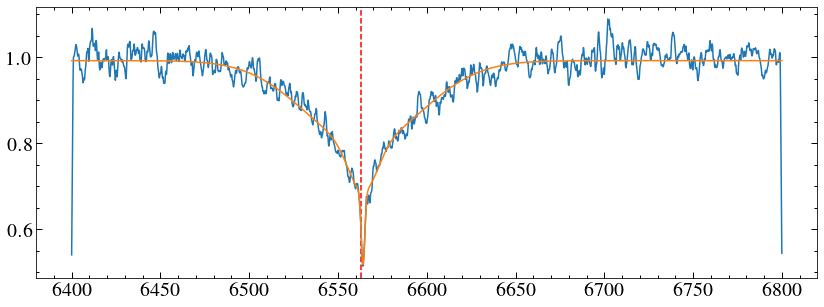

In [404]:
fitter = fitting.LevMarLSQFitter()
norms = []
means = []
amplitudes = []
stds = []
clean_dates = []

halpha = 6562.77

def tiedfunc(gg_init):
    mean = gg_init.mean_0.value
    return mean

#sp_lines, xs = , line_list
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    if x == -1:
        
   # print(s)
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        slines = get_shifted_lines(x, lines)
        mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
        mask2 = (w> 6400) & (w < 6800) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
        #plt.plot(w, f)
        date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
        clean_dates.append(date)


        plt.figure() 

        plt.axvline(halpha, c='r', ls='--')
        gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.5, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0)
        gg_init.mean_1.tied=tiedfunc
        gg_init.mean_2.tied=tiedfunc
      


        gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
        #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

       # print(gg_fit)
        #print(fit_e)

        plt.plot(w, f)
        plt.plot(w, gg_fit(w))
        plt.show()
        
        norms.append(gg_fit[3].amplitude.value)
        means.append([gg_fit[0].mean.value, gg_fit[1].mean.value, gg_fit[2].mean.value])
        amplitudes.append([gg_fit[0].amplitude.value, gg_fit[1].amplitude.value, gg_fit[2].amplitude.value])
        stds.append([gg_fit[0].stddev.value, gg_fit[1].stddev.value, gg_fit[2].stddev.value])

  
    
    

<ErrorbarContainer object of 3 artists>

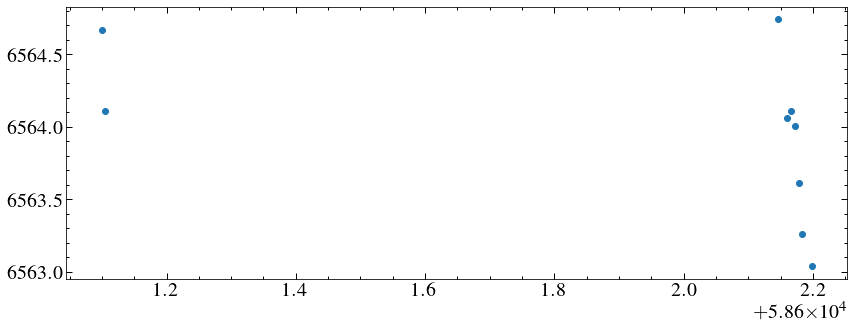

In [389]:
means_av = np.mean(means, axis=1)
means_av
plt.errorbar(clean_dates, means_av, ls='none', marker='o')

<ErrorbarContainer object of 3 artists>

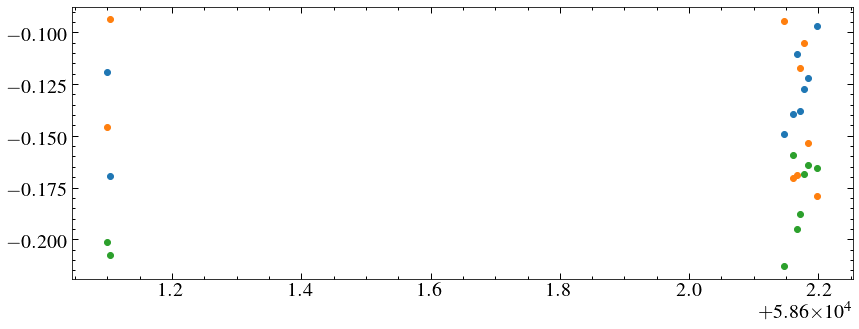

In [406]:
#plt.errorbar(clean_dates, , ls='none', marker='o')
amplitudes, stds = np.array(amplitudes), np.array(stds)
plt.errorbar(clean_dates, amplitudes[:,0], ls='none', marker='o')
plt.errorbar(clean_dates, amplitudes[:,1], ls='none', marker='o')
plt.errorbar(clean_dates, amplitudes[:,2], ls='none', marker='o')


<ErrorbarContainer object of 3 artists>

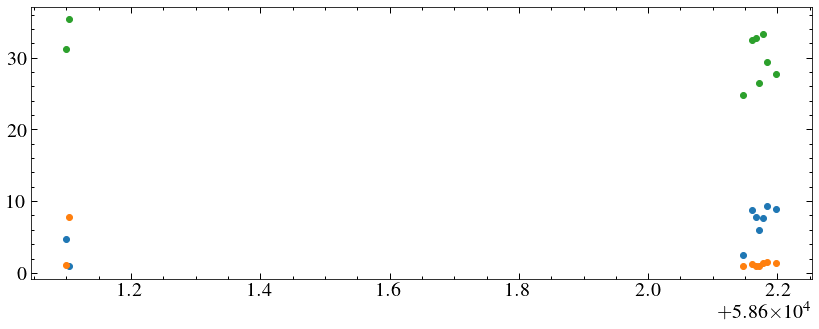

In [407]:
plt.errorbar(clean_dates, stds[:,0], ls='none', marker='o')
plt.errorbar(clean_dates, stds[:,1], ls='none', marker='o')
plt.errorbar(clean_dates, stds[:,2], ls='none', marker='o')


In [45]:
period

4.217385925598945